<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment5/Assignment_5_RNN_IDL_Meghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)


#### Import Statements

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

#### Loading Data

In [ ]:
vocab_size = 40000
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words= vocab_size)

In [ ]:
print(train_sequences[:4])
print(train_labels[:4])

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 825

#### Index and Word mappings

In [ ]:
word_to_index = tf.keras.datasets.imdb.get_word_index()
index_to_word = dict((index, word) for (word, index) in word_to_index.items())

Max sequence length: 2494
Min sequence length: 11


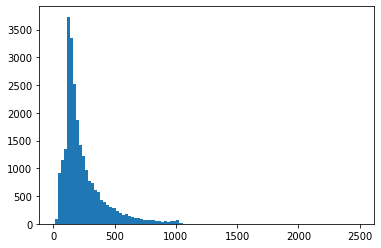

In [ ]:
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = max(sequence_lengths)
min_len = min(sequence_lengths)
print("Max sequence length:", max_len)
print("Min sequence length:",min_len)

plt.hist(sequence_lengths, bins=100)
plt.show()

#### Padding sequences

In [ ]:
max_words_length = 300

train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_words_length, padding = "pre", truncating = "pre")
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_words_length, padding = "pre", truncating = "pre")

#### Train and Test data set

In [ ]:
train_labels = train_labels.reshape(-1).astype(np.int32)
test_labels = test_labels.reshape(-1).astype(np.int32)

train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels)).shuffle(25000).batch(128)
test_data = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels)).batch(128)

#### Equations

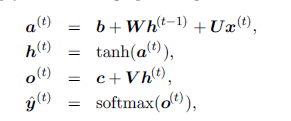

#### **RNN Loop**
###### *x(t)_size: batch_size x (1 x vocab_size) -> eg: 128 x (1 x 20000)*

###### U_input_to_hidden:  vocab_size x no_of_hidden_units -> eg: 20000 x 64
###### W_hidden_to_hidden: no_of_hidden_units x no_of_hidden_units -> eg: 64 x 64
###### b_bias: 1 x no_of_hidden_units -> eg: 1 x 64

###### *a(t)_size = h(t)_size = 1 x  no_of_hidden_units -> eg: 1 x 64*

###### V_hidden_to_output: no_of_hidden_units x no_of_output_units -> eg: 64 x 2
###### c_bias: 1 x no_of_output_units -> eg: 1 x 2

###### *o(t)_size: 1 x no_of_output_units -> eg : 1 x 2*
###### *y(t)_size: 1*

In [ ]:
def rnn_loop(sequences, model):
  old_state = model.prev_h
  #sequences_one_hot = tf.one_hot(sequences, depth = vocab_size)
  for step in range(max_words_length):
    #x_t = sequences_one_hot[:,step]
    x_t = sequences[:, step]
    x_t = tf.one_hot(x_t, depth=vocab_size)
    a_t = model.b + tf.matmul(old_state, model.W_h_h) + tf.matmul(x_t, model.U_x_h)
    new_state = tf.nn.tanh(a_t)
    old_state = new_state

  o_t = model.c + tf.matmul(new_state, model.V_h_o)

  return o_t

#### Model Train

In [ ]:
def start_model_train(train_data, model):
  print("-----------Model train-------------")
  optimizer = model.optimizer
  U_x_h, W_h_h, b, V_h_o, c = model.U_x_h, model.W_h_h, model.b, model.V_h_o, model.c
  for num_of_epochs in range(model.epochs):
    print("Epoch:", num_of_epochs)
    for step, (sequence_batch, label_batch) in enumerate(train_data):
      with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch, model)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label_batch))
     
      grads = tape.gradient(xent, [U_x_h, W_h_h, b, V_h_o, c])
      optimizer.apply_gradients(zip(grads, [U_x_h, W_h_h, b, V_h_o, c]))
     
      if not step % 50:
        print("Step: ", step)
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
  
  return U_x_h, W_h_h, b, V_h_o, c

#### Model Test

In [ ]:
def start_model_test(test_data, model, U_x_h, W_h_h, b, V_h_o, c):
  print("-----------Model test-------------")
  test_accuracy = []
  for step, (sequence_batch, label_batch) in enumerate(test_data):
    logits = rnn_loop(sequence_batch, model)
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch), tf.float32))
    test_accuracy.append(acc)

  print("Final Test Accuracy: {}".format(sum(test_accuracy)/len(test_accuracy)))

In [ ]:
class Model_1:

  def __init__(self, **kwargs):
     super().__init__(**kwargs)
     self.U_x_h = tf.Variable(tf.random.uniform([vocab_size, 64],minval=-0.1,maxval=0.1, dtype=np.float32))
     self.W_h_h = tf.Variable(tf.random.uniform([64, 64], minval=-0.1, maxval=0.1, dtype=np.float32))
     self.b = tf.Variable(tf.zeros([1, 64],tf.float32))
     self.V_h_o = tf.Variable(tf.random.uniform([64, 2],minval=-0.1,maxval=0.1, dtype=np.float32))
     self.c = tf.Variable(tf.zeros([1, 2],tf.float32))

     self.prev_h = tf.Variable(tf.zeros([1, 64],tf.float32))

     self.optimizer = tf.keras.optimizers.Adam()
     self.epochs = 10

In [ ]:
class Model_2:

  def __init__(self, **kwargs):
     super().__init__(**kwargs)
     self.U_x_h = tf.Variable(tf.random.uniform([vocab_size, 64], minval=-0.1, maxval=0.1, dtype=np.float32))
     self.W_h_h = tf.Variable(tf.random.uniform([64, 64], minval=-0.1, maxval=0.1, dtype=np.float32))
     self.b = tf.Variable(tf.zeros([1, 64],tf.float32))
     self.V_h_o = tf.Variable(tf.random.uniform([64, 1], minval=-0.1, maxval=0.1, dtype=np.float32))
     self.c = tf.Variable(tf.zeros([1, 1],tf.float32))

     self.prev_h = tf.Variable(tf.zeros([1, 64],tf.float32))

     self.optimizer = tf.keras.optimizers.Adam()
     self.epochs = 30

In [ ]:
class Model_3:

  def __init__(self, **kwargs):
     super().__init__(**kwargs)
     self.U_x_h = tf.Variable(tf.random.uniform([vocab_size, 128],minval=-0.1,maxval=0.1, dtype=np.float32))
     self.W_h_h = tf.Variable(tf.random.uniform([128, 128], minval=-0.1, maxval=0.1, dtype=np.float32))
     self.b = tf.Variable(tf.zeros([1, 128],tf.float32))
     self.V_h_o = tf.Variable(tf.random.uniform([128, 2],minval=-0.1,maxval=0.1, dtype=np.float32))
     self.c = tf.Variable(tf.zeros([1, 2],tf.float32))

     self.prev_h = tf.Variable(tf.zeros([1, 128],tf.float32))

     self.optimizer = tf.keras.optimizers.Adam()
     self.epochs = 20

### **Model 1**
##### - Hidden units size: 64
##### - Output unit size: 2
##### - Output activation function: Softmax
##### - Epochs: 10
##### - Vocab_size: 20000
##### - Max words length: 300
##### - Padding: post
##### - One hot encoding for every batch

In [ ]:
model_1 = Model_1()
U_x_h, W_h_h, b, V_h_o, c = start_model_train(train_data, model_1)
start_model_test(test_data, model_1, U_x_h, W_h_h, b, V_h_o, c)

-----------Model train-------------
Epoch: 0
Step:  0
Loss: 0.696983814239502 Accuracy: 0.4609375
Step:  50
Loss: 0.6933837532997131 Accuracy: 0.4765625
Step:  100
Loss: 0.6923089027404785 Accuracy: 0.5
Step:  150
Loss: 0.6912754774093628 Accuracy: 0.5078125
Epoch: 1
Step:  0
Loss: 0.6713583469390869 Accuracy: 0.53125
Step:  50
Loss: 0.6589031219482422 Accuracy: 0.59375
Step:  100
Loss: 0.6297928690910339 Accuracy: 0.6015625
Step:  150
Loss: 0.6451587677001953 Accuracy: 0.5625
Epoch: 2
Step:  0
Loss: 0.6143935918807983 Accuracy: 0.625
Step:  50
Loss: 0.611807107925415 Accuracy: 0.6015625
Step:  100
Loss: 0.6169560551643372 Accuracy: 0.484375
Step:  150
Loss: 0.604966402053833 Accuracy: 0.6484375
Epoch: 3
Step:  0
Loss: 0.6075243353843689 Accuracy: 0.5703125
Step:  50
Loss: 0.5892278552055359 Accuracy: 0.59375
Step:  100
Loss: 0.5346689224243164 Accuracy: 0.6875
Step:  150
Loss: 0.5922883749008179 Accuracy: 0.609375
Epoch: 4
Step:  0
Loss: 0.5623510479927063 Accuracy: 0.6796875
Step:  5

### **Model 2**
##### - Hidden units size: 64
##### - Output unit size: 1
##### - Output activation function: Sigmoid
##### - Epochs: 30
##### - Vocab_size: 20000
##### - Max words length: 300
##### - Padding: post
##### - One hot encoding for every batch

In [ ]:
model_2 = Model_2()
U_x_h, W_h_h, b, V_h_o, c = start_model_train(train_data, model_2)
start_model_test(test_data, model_2, U_x_h, W_h_h, b, V_h_o, c)

-----------Model train-------------
Epoch: 0
Step:  0
Loss: 0.6924635171890259 Accuracy: 0.4765625
Step:  50
Loss: 0.6921123266220093 Accuracy: 0.578125
Step:  100
Loss: 0.6881871223449707 Accuracy: 0.5
Step:  150
Loss: 0.6972715258598328 Accuracy: 0.4921875
Epoch: 1
Step:  0
Loss: 0.6837220788002014 Accuracy: 0.453125
Step:  50
Loss: 0.6536791324615479 Accuracy: 0.484375
Step:  100
Loss: 0.6601487398147583 Accuracy: 0.5
Step:  150
Loss: 0.6848399639129639 Accuracy: 0.46875
Epoch: 2
Step:  0
Loss: 0.6229733228683472 Accuracy: 0.46875
Step:  50
Loss: 0.6111183166503906 Accuracy: 0.484375
Step:  100
Loss: 0.6328283548355103 Accuracy: 0.453125
Step:  150
Loss: 0.5959903001785278 Accuracy: 0.4609375
Epoch: 3
Step:  0
Loss: 0.5918513536453247 Accuracy: 0.4296875
Step:  50
Loss: 0.6068836450576782 Accuracy: 0.5234375
Step:  100
Loss: 0.6558130383491516 Accuracy: 0.5234375
Step:  150
Loss: 0.6062442064285278 Accuracy: 0.53125
Epoch: 4
Step:  0
Loss: 0.5590101480484009 Accuracy: 0.53125
Step: 

### **Model 3**
##### - Hidden units size: 128
##### - Output unit size: 2
##### - Output activation function: Softmax
##### - Epochs: 20
##### - Vocab_size: 40000
##### - Max words length: 300
##### - Padding: pre
##### - One hot encoding for every step ( cannot be batch level due to OOM error for 40000 vocab size), comparitively slow

In [ ]:
model_3 = Model_3()
U_x_h, W_h_h, b, V_h_o, c = start_model_train(train_data, model_3)
start_model_test(test_data, model_3, U_x_h, W_h_h, b, V_h_o, c)

-----------Model train-------------
Epoch: 0
Step:  0
Loss: 0.693466067314148 Accuracy: 0.4765625
Step:  50
Loss: 0.6623430252075195 Accuracy: 0.6328125
Step:  100
Loss: 0.5894943475723267 Accuracy: 0.6953125
Step:  150
Loss: 0.5674940347671509 Accuracy: 0.6796875
Epoch: 1
Step:  0
Loss: 0.5117217302322388 Accuracy: 0.78125
Step:  50
Loss: 0.3901035189628601 Accuracy: 0.8515625
Step:  100
Loss: 0.3111390173435211 Accuracy: 0.859375
Step:  150
Loss: 0.35048192739486694 Accuracy: 0.8515625
Epoch: 2
Step:  0
Loss: 0.22653040289878845 Accuracy: 0.890625
Step:  50
Loss: 0.18994292616844177 Accuracy: 0.921875
Step:  100
Loss: 0.1192915067076683 Accuracy: 0.953125
Step:  150
Loss: 0.21812835335731506 Accuracy: 0.9140625
Epoch: 3
Step:  0
Loss: 0.06736163794994354 Accuracy: 0.984375
Step:  50
Loss: 0.12817560136318207 Accuracy: 0.953125
Step:  100
Loss: 0.024618934839963913 Accuracy: 0.9921875
Step:  150
Loss: 0.22736451029777527 Accuracy: 0.921875
Epoch: 4
Step:  0
Loss: 0.031235460191965103 

## Questions:

#### **Q1) Why is this wasteful? Can you think of a smarter padding scheme that is more efficient? Consider the fact that RNNs can work on arbitrary sequence lengths, and that training minibatches are pretty much independent of each other**

1.   Because as per the histogram plot in the above plots, we can see that most of the sequence lengths are between 0-500 and if we pad to the max length then most of the neurons are initialised with dummy values which is wasteful for computation.

2.   Alternative way is to pad at batch level by taking the average length of sequences in that particular batch.


#### **Q2) Between truncating long sequences and removing them, which option do you think is better? Why?**

1.   Post trunctaing could be better, but here tried different configs with both pre and post truncating but the results are same.


#### **Q3) Can you think of a way to avoid the one-hot vectors completely? Even if you cannot implement it, a conceptual idea is fine.**

1.   Word Embeddings


#### **Q4) How can it be that we can choose how many outputs we have, i.e. how can both be correct? Are there differences between both choices as well as (dis)advantages relative to each other?**

1. Use softmax if the output neurons size is 2 and whichever wins will be the target
2. Use sigmoid if the output neuron size is 1 and get a value, based on the value classify it as 0 or 1 ( by threshold of 0.5)
3. Both almost gave same results. Using softmax accuracy was 2 percent more.

#### **Q5) All sequences start with the same special “beginning of sequence” token (coded by index 1). Given this fact, is there a point in learning an initial state? Why (not)?**

1. Same information might be propagated from the initial state to the next states for every sequence which might not be helpful for classification purpose.


#### **Q6) All sequences start with the same special “beginning of sequence” token (coded by index 1). Given this fact, is there a point in learning an initial state? Why (not)?**

1. Same information might be propagated from the initial state to the next states for every sequence which might not be helpful for classification purpose.

#### **Q6) Pad_sequences allows for pre or post padding. Try both to see the difference. Which option do you think is better? Recall that we use the final time step output from our model.**

1. Post padding is recommended.

#### **Q7) Can you think of a way to prevent the RNN from computing new states on padded time steps? One idea might be to “pass through” the previous state in case the current time step is padding. Note that, within a batch, some sequences might be padded for a given time step while others are not.**

1. May be instead of setting max lenth sequence at global level for the entire dataset. We can set the max length of the sequence at batch level since RNN can accept variable input size. By taking the average length in the current batch sequences and then apply padding. But here we need to compute the tensors at batch level which will be time consuming.

2. The above description might not prevent padding at all, we can go sequence by sequence which can avoid padding. It is time consuming.

#### **Q8) What could be the advantage of using methods like the above? What are disadvantages? Can you think of other methods to incorporate the full output sequence instead of just the final step?**

1. We can have output units at each time step and before sending it to the loss function take average of all the output units and send them.